In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from functools import partial
import typing
from jax.numpy import asarray as æ

/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


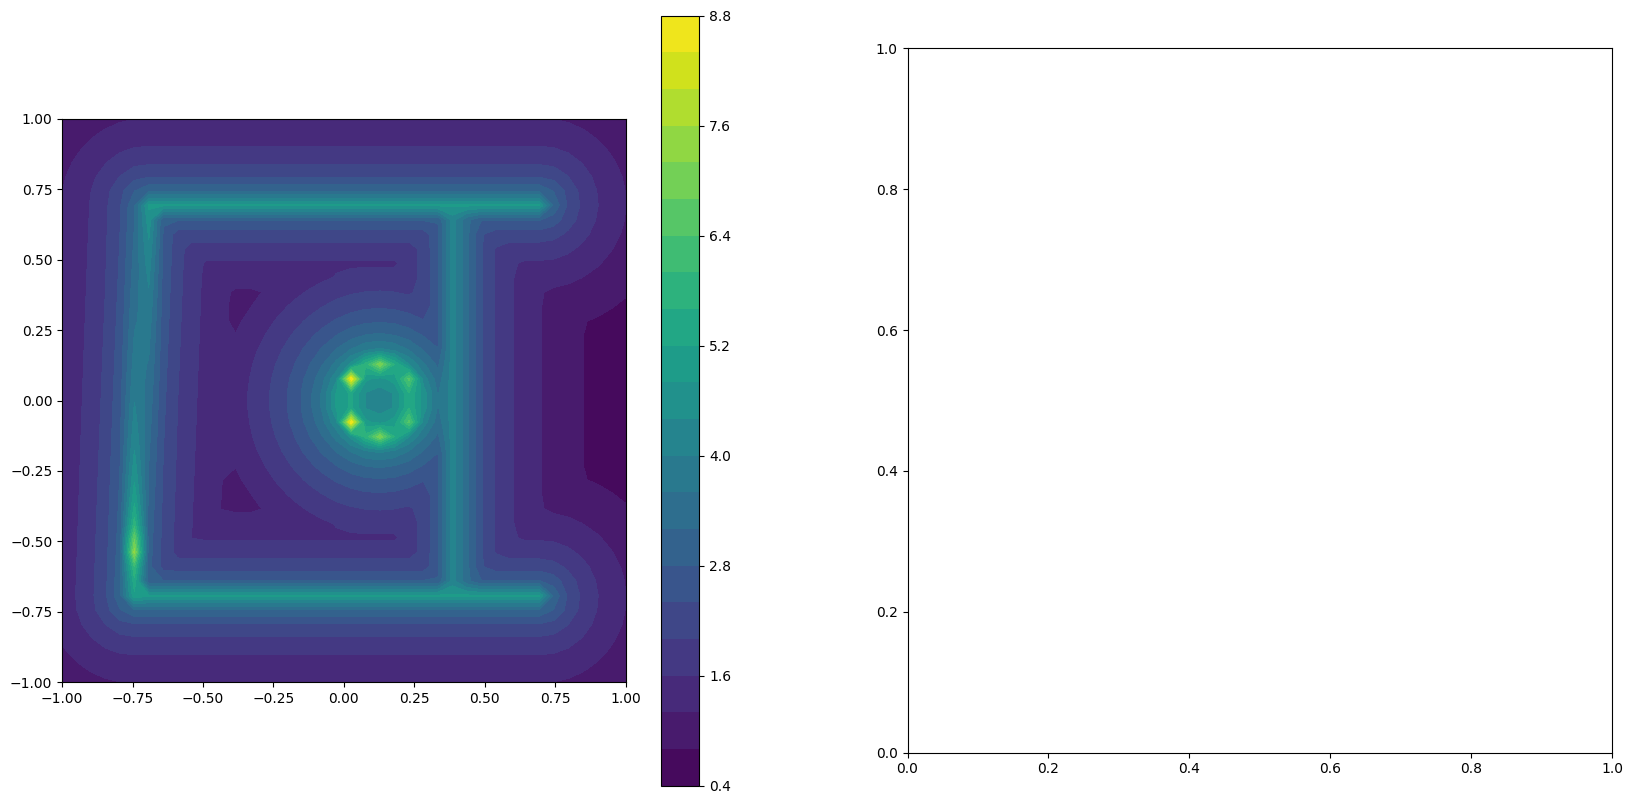

In [ ]:
@partial(jax.jit, static_argnums=(1, 2))
def line_sdf(pos, start, end__):
    diff = end__ - start
    length = jnp.linalg.norm(diff)
    projected = jnp.dot(pos - start, diff)
    on_line = projected / length
    return jax.lax.cond(
        on_line < 0,
        lambda: jnp.linalg.norm(pos - start),
        lambda: jax.lax.cond(
            on_line > length,
            lambda: jnp.linalg.norm(pos - end__),
            lambda: jnp.linalg.norm((pos - start) - on_line * diff / length),
        ),
    )


def ellipse_sdf(pos, center, positive_definite_mat, radius=1.0):
    (eigvals, eigvecs) = jnp.linalg.eig(positive_definite_mat)
    sorted = jnp.argsort(eigvals)
    eigvals = eigvals[sorted].real
    eigvecs = eigvecs[:, sorted].real

    pmc = pos - center

    l1 = pmc @ eigvecs[:, 0] * eigvals[0]
    l2 = pmc @ eigvecs[:, 1] * eigvals[1]

    return jnp.abs(l1**2 + l2**2 - radius**2)


line_sdf = jax.jit(line_sdf)


line1 = (jnp.array([0.4, 0.7]), jnp.array([0.4, -0.7]))
line2 = (jnp.array([0.7, -0.7]), jnp.array([-0.75, -0.7]))
line3 = (jnp.array([-0.75, -0.7]), jnp.array([-0.7, 0.7]))
line4 = (jnp.array([-0.7, 0.7]), jnp.array([0.7, 0.7]))
lines = jnp.array([line1, line2, line3, line4])


ellipse_matrix = jnp.array([[1.0, 0.0], [0.0, 1.0]])


def full_sdf(pos):
    return jnp.min(
        jnp.append(
            jax.vmap(lambda line: line_sdf(pos, line[0], line[1]))(lines),
            ellipse_sdf(pos, jnp.array([0.125, 0.0]), ellipse_matrix, 0.25 / 2),
        )
    )


@jax.jit
def border_potential(pos, scale):
    return -jnp.log(jnp.clip((scale *   full_sdf(pos)))


fig, (loss_ax, grad_ax) = plt.subplots(1, 2, figsize=(20, 10))
loss_ax.set_aspect("equal")
grad_ax.set_aspect("equal")

# plot sdf
xs = np.linspace(-1, 1, 40)
ys = np.linspace(-1, 1, 40)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)
a = np.array([-0.5, -0.5])
b = np.array([0.5, 0.5])
for i in range(len(xs)):
    for j in range(len(ys)):
        p = jnp.array([xs[i], ys[j]])
        Z[j, i] = border_potential(p, 1)

# contour = loss_ax.contour(X, Y, Z, levels=np.arange(-1, 1, 0.1))
contour = loss_ax.contourf(X, Y, Z, levels=20)
fig.colorbar(contour)

# loss_ax.grid()

In [3]:
n_points = 3


class Points(typing.NamedTuple):
    pos: npt.NDArray[np.float64]

    def step(self, *, gradient: "Points", lr: float):
        return Points(pos=self.pos - jnp.clip(gradient.pos * lr, max=0.1, min=-0.1))


def foo(p1: Points, p2: Points, lr: float):
    return p1.step(gradient=p2, lr=lr)  # this step here


class Parameters(typing.NamedTuple):
    points: Points

    def step(self, gradients: "Parameters", lr: float):
        return Parameters(points=self.points.step(gradient=gradients.points, lr=lr))


initial_parameters = Parameters(
    Points(0.5 * (0.5 - np.random.rand(n_points * 2).reshape(n_points, 2)))
)
print(initial_parameters)

Parameters(points=Points(pos=array([[-0.1997246 ,  0.18134549],
       [ 0.05402228, -0.1453225 ],
       [ 0.05373118, -0.00864349]])))


In [4]:
def pair_loss(points, i, j):
    return jnp.exp(-4 * jnp.linalg.norm(points.pos[i] - points.pos[j]))


@partial(jax.jit, static_argnames=["n_points"])
def loss_func(input: Parameters, n_points: int, barrier_scaling: float) -> float:
    score = 0
    for i in range(n_points):
        score += border_potential(input.points.pos[i], barrier_scaling)
        # for j in range(i + 1, n_points):
        #     score += 0 * pair_loss(input.points, i, j)
        # for j in range(n_points):
        #     if i == j:
        #         continue
        #     score += -jnp.log(
        #         ellipse_sdf(
        #             input.points.pos[i], input.points.pos[j], ellipse_matrix, 0.2
        #         )
        #     )
    return score


loss_func(initial_parameters, n_points, 1.0)
loss_grad = jax.jit(
    jax.grad(
        partial(loss_func, n_points=n_points),
        argnums=0,
    )
)
loss_grad(initial_parameters, barrier_scaling=1.0)

Parameters(points=Points(pos=Array([[  5.2926717,  -2.955742 ],
       [ 13.479172 ,  27.59777  ],
       [-13.612554 ,  -1.6509327]], dtype=float32)))

Parameters(points=Points(pos=array([[-0.1997246 ,  0.18134549],
       [ 0.05402228, -0.1453225 ],
       [ 0.05373118, -0.00864349]])))

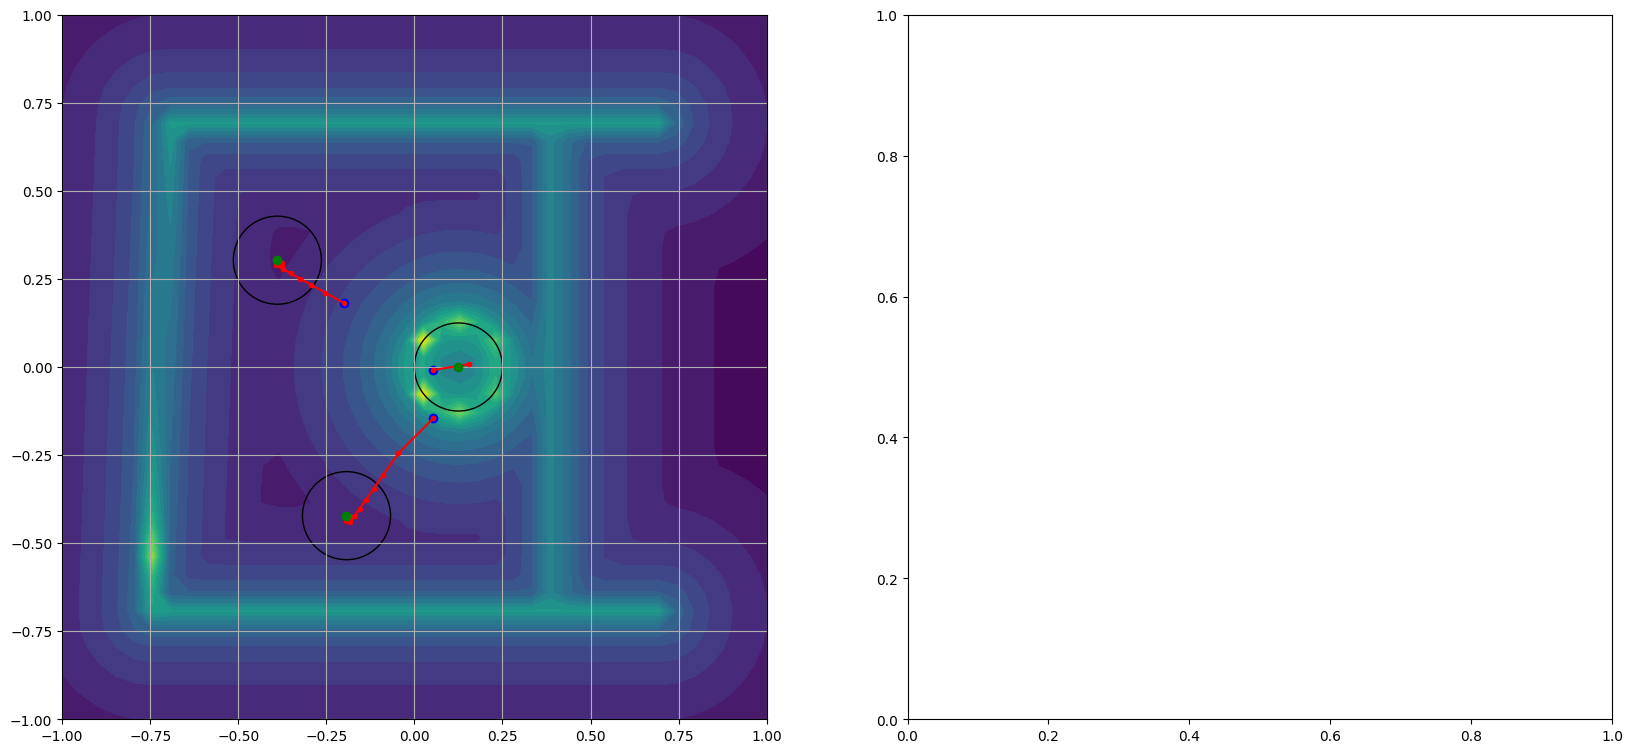

In [5]:
import jax.scipy.optimize
import matplotlib


class OptimizerState(typing.NamedTuple):
    params: Parameters
    lr: float


all_steps = None

x0 = initial_parameters

barrier_scalings = [1.0, 10.0, 100.0, 1000.0]
lrs = [0.01, 0.03, 1e-2, 1e-3]

for barrier_scaling, lr in zip(barrier_scalings, lrs):
    start_state = OptimizerState(params=x0, lr=lr)

    loss_grad = jax.jit(
        jax.grad(
            partial(loss_func, n_points=n_points),
            argnums=0,
        )
    )

    def step_grad(state: OptimizerState, _):
        lr = state.lr
        gradient = loss_grad(state.params, barrier_scaling=barrier_scaling)
        new_params = state.params.step(
            gradient,
            lr,
        )
        new_lr = 0.9 * lr
        output_state = OptimizerState(params=new_params, lr=new_lr)
        return output_state, output_state

    (output, steps) = jax.lax.scan(step_grad, start_state, length=10)
    x0 = output.params
    # if all_steps is None:
    #     all_steps = steps.params
    # else:
    #     all_steps = jnp.stack((all_steps, steps.params), axis=0)
    break


fig, (conv, update) = plt.subplots(1, 2, figsize=(20, 10))
conv.set_aspect("equal")
conv.set_xlim(-1, 1)
conv.set_ylim(-1, 1)
conv.contourf(X, Y, Z, levels=20)


for n in range(steps.params.points.pos.shape[1]):
    conv.plot(
        [initial_parameters.points.pos[n, 0]]
        + steps.params.points.pos[:, n, 0].tolist(),
        [initial_parameters.points.pos[n, 1]]
        + steps.params.points.pos[:, n, 1].tolist(),
        color="red",
        marker=".",
        linestyle="solid",
    )
conv.scatter(
    initial_parameters.points.pos[:, 0],
    initial_parameters.points.pos[:, 1],
    color="blue",
)
conv.scatter(
    x0.points.pos[:, 0],
    x0.points.pos[:, 1],
    color="green",
    zorder=10,
)

for points in x0.points.pos:
    conv.add_patch(matplotlib.patches.Circle(points, radius=0.125, fill=False))


conv.grid()

update.set_aspect("equal")
# update.plot(*steps)
initial_parameters